In [19]:
from model import CIFAR10CNN2, CIFAR10CNN3
from utils import Cifar10Dataset
from train import Trainer

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
%matplotlib inline


import albumentations as A
from albumentations.pytorch import ToTensorV2

#### Train Transforms using Albumentations

In [2]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                        fill_value=0.4734),
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616),
            p =1.0
        ),
        ToTensorV2()
    ],
    p=1.0
)

#### Test Transforms using Albumentations

In [3]:
test_transforms = A.Compose(
    [
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616),
            p =1.0
        ),
        ToTensorV2()
    ],
    p=1.0
)

In [8]:
class args():

    def __init__(self,device = 'cuda' ,use_cuda = True) -> None:

        self.batch_size = 128

        self.device = device

        self.use_cuda = use_cuda

        self.kwargs = {'num_workers': 4, 'pin_memory': True} if self.use_cuda else {}
        

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
        
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

CUDA Available? True


In [9]:
trainset = Cifar10Dataset(root='./data', train=True,
                                        download=True, transform=train_transforms)

                                        

trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

Files already downloaded and verified


In [10]:
testset = Cifar10Dataset(root='./data', train=False,
                                        download=True, transform=test_transforms)

testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


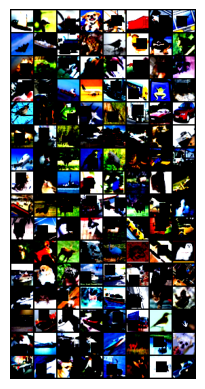

In [11]:
images, _ = next(iter(trainloader))
# images = images.numpy()

grid = torchvision.utils.make_grid(images)
grid = grid.numpy().transpose((1,2,0))

plt.imshow(grid)
plt.axis('off')
plt.show()

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [22]:
model1 = CIFAR10CNN2(num_classes=10).to(device)

In [23]:
model1_trainer = Trainer(model1)

In [24]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CIFAR10CNN2().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]             640
            Conv2d-5           [-1, 64, 28, 28]           4,160
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]             640
            Conv2d-9           [-1, 64, 28, 28]           4,160
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]             640
           Conv2d-13           [-1, 64, 28, 28]           4,160
      BatchNorm2d-14           [-1

In [28]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [29]:
from torch.optim.lr_scheduler import StepLR, LambdaLR

model =  CIFAR10CNN2().to(device)
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 0


Loss=1.319269061088562 Batch_id=390 Accuracy=42.49: 100%|████████████████████████████| 391/391 [00:20<00:00, 18.63it/s]



Test set: Average loss: 0.0096, Accuracy: 5682/10000 (56.82%)

EPOCH: 1


Loss=1.19991934299469 Batch_id=390 Accuracy=53.90: 100%|█████████████████████████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 0.0080, Accuracy: 6323/10000 (63.23%)

EPOCH: 2


Loss=1.1187125444412231 Batch_id=390 Accuracy=58.46: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.27it/s]



Test set: Average loss: 0.0075, Accuracy: 6696/10000 (66.96%)

EPOCH: 3


Loss=1.1585661172866821 Batch_id=390 Accuracy=61.76: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.31it/s]



Test set: Average loss: 0.0066, Accuracy: 7093/10000 (70.93%)

EPOCH: 4


Loss=0.8349015116691589 Batch_id=390 Accuracy=64.04: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.28it/s]



Test set: Average loss: 0.0062, Accuracy: 7227/10000 (72.27%)

EPOCH: 5


Loss=1.217560052871704 Batch_id=390 Accuracy=65.58: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.00it/s]



Test set: Average loss: 0.0068, Accuracy: 7063/10000 (70.63%)

EPOCH: 6


Loss=1.1786081790924072 Batch_id=390 Accuracy=66.87: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.31it/s]



Test set: Average loss: 0.0057, Accuracy: 7513/10000 (75.13%)

EPOCH: 7


Loss=0.7552996873855591 Batch_id=390 Accuracy=67.68: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.28it/s]



Test set: Average loss: 0.0054, Accuracy: 7636/10000 (76.36%)

EPOCH: 8


Loss=0.9880145192146301 Batch_id=390 Accuracy=68.87: 100%|███████████████████████████| 391/391 [00:21<00:00, 17.84it/s]



Test set: Average loss: 0.0052, Accuracy: 7681/10000 (76.81%)

EPOCH: 9


Loss=0.794843316078186 Batch_id=390 Accuracy=69.78: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.22it/s]



Test set: Average loss: 0.0049, Accuracy: 7830/10000 (78.30%)

EPOCH: 10


Loss=1.0437480211257935 Batch_id=390 Accuracy=70.40: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.27it/s]



Test set: Average loss: 0.0049, Accuracy: 7830/10000 (78.30%)

EPOCH: 11


Loss=0.7529229521751404 Batch_id=390 Accuracy=70.96: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 0.0051, Accuracy: 7793/10000 (77.93%)

EPOCH: 12


Loss=0.7159638404846191 Batch_id=390 Accuracy=71.56: 100%|███████████████████████████| 391/391 [00:23<00:00, 16.29it/s]



Test set: Average loss: 0.0047, Accuracy: 7995/10000 (79.95%)

EPOCH: 13


Loss=0.7878557443618774 Batch_id=390 Accuracy=72.06: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.52it/s]



Test set: Average loss: 0.0046, Accuracy: 7968/10000 (79.68%)

EPOCH: 14


Loss=0.6853529214859009 Batch_id=390 Accuracy=72.28: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.29it/s]



Test set: Average loss: 0.0044, Accuracy: 8046/10000 (80.46%)

EPOCH: 15


Loss=0.5699108839035034 Batch_id=390 Accuracy=73.37: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.24it/s]



Test set: Average loss: 0.0046, Accuracy: 8007/10000 (80.07%)

EPOCH: 16


Loss=0.859006404876709 Batch_id=390 Accuracy=73.25: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 0.0045, Accuracy: 8056/10000 (80.56%)

EPOCH: 17


Loss=0.6570026278495789 Batch_id=390 Accuracy=73.55: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.62it/s]



Test set: Average loss: 0.0045, Accuracy: 7984/10000 (79.84%)

EPOCH: 18


Loss=0.739359438419342 Batch_id=390 Accuracy=74.28: 100%|████████████████████████████| 391/391 [00:20<00:00, 18.82it/s]



Test set: Average loss: 0.0042, Accuracy: 8150/10000 (81.50%)

EPOCH: 19


Loss=0.8534054756164551 Batch_id=390 Accuracy=74.44: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.87it/s]



Test set: Average loss: 0.0044, Accuracy: 8096/10000 (80.96%)

EPOCH: 20


Loss=0.8753746747970581 Batch_id=390 Accuracy=74.90: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.85it/s]



Test set: Average loss: 0.0042, Accuracy: 8192/10000 (81.92%)

EPOCH: 21


Loss=0.6157063245773315 Batch_id=390 Accuracy=75.07: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.69it/s]



Test set: Average loss: 0.0040, Accuracy: 8263/10000 (82.63%)

EPOCH: 22


Loss=0.7166267037391663 Batch_id=390 Accuracy=75.62: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.74it/s]



Test set: Average loss: 0.0042, Accuracy: 8213/10000 (82.13%)

EPOCH: 23


Loss=0.6345826387405396 Batch_id=390 Accuracy=75.78: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.82it/s]



Test set: Average loss: 0.0039, Accuracy: 8313/10000 (83.13%)

EPOCH: 24


Loss=0.7625342011451721 Batch_id=390 Accuracy=76.12: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.83it/s]



Test set: Average loss: 0.0042, Accuracy: 8222/10000 (82.22%)

EPOCH: 25


Loss=0.5149210095405579 Batch_id=390 Accuracy=76.04: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.31it/s]



Test set: Average loss: 0.0042, Accuracy: 8166/10000 (81.66%)

EPOCH: 26


Loss=0.46139341592788696 Batch_id=390 Accuracy=76.29: 100%|██████████████████████████| 391/391 [00:21<00:00, 18.20it/s]



Test set: Average loss: 0.0046, Accuracy: 8108/10000 (81.08%)

EPOCH: 27


Loss=0.7815054655075073 Batch_id=390 Accuracy=76.48: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.53it/s]



Test set: Average loss: 0.0039, Accuracy: 8320/10000 (83.20%)

EPOCH: 28


Loss=0.776668906211853 Batch_id=390 Accuracy=77.08: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.18it/s]



Test set: Average loss: 0.0039, Accuracy: 8311/10000 (83.11%)

EPOCH: 29


Loss=0.4954877495765686 Batch_id=390 Accuracy=77.00: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.03it/s]



Test set: Average loss: 0.0046, Accuracy: 8061/10000 (80.61%)

EPOCH: 30


Loss=0.8496403694152832 Batch_id=390 Accuracy=77.23: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.37it/s]



Test set: Average loss: 0.0038, Accuracy: 8331/10000 (83.31%)

EPOCH: 31


Loss=0.630569338798523 Batch_id=390 Accuracy=77.17: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.44it/s]



Test set: Average loss: 0.0039, Accuracy: 8300/10000 (83.00%)

EPOCH: 32


Loss=0.6705737709999084 Batch_id=390 Accuracy=77.54: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.65it/s]



Test set: Average loss: 0.0037, Accuracy: 8410/10000 (84.10%)

EPOCH: 33


Loss=0.7090975046157837 Batch_id=390 Accuracy=78.00: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.48it/s]



Test set: Average loss: 0.0038, Accuracy: 8386/10000 (83.86%)

EPOCH: 34


Loss=0.6069981455802917 Batch_id=390 Accuracy=77.84: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.48it/s]



Test set: Average loss: 0.0038, Accuracy: 8369/10000 (83.69%)

EPOCH: 35


Loss=0.42124900221824646 Batch_id=390 Accuracy=77.93: 100%|██████████████████████████| 391/391 [00:21<00:00, 18.32it/s]



Test set: Average loss: 0.0041, Accuracy: 8257/10000 (82.57%)

EPOCH: 36


Loss=0.6059666872024536 Batch_id=390 Accuracy=78.17: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.40it/s]



Test set: Average loss: 0.0038, Accuracy: 8400/10000 (84.00%)

EPOCH: 37


Loss=0.6996375322341919 Batch_id=390 Accuracy=78.54: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.32it/s]



Test set: Average loss: 0.0035, Accuracy: 8488/10000 (84.88%)

EPOCH: 38


Loss=0.768610954284668 Batch_id=390 Accuracy=78.33: 100%|████████████████████████████| 391/391 [00:20<00:00, 18.77it/s]



Test set: Average loss: 0.0035, Accuracy: 8468/10000 (84.68%)

EPOCH: 39


Loss=0.8966341018676758 Batch_id=390 Accuracy=78.57: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.64it/s]



Test set: Average loss: 0.0039, Accuracy: 8365/10000 (83.65%)

EPOCH: 40


Loss=0.6685110926628113 Batch_id=390 Accuracy=78.57: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.68it/s]



Test set: Average loss: 0.0035, Accuracy: 8487/10000 (84.87%)

EPOCH: 41


Loss=0.5504958629608154 Batch_id=390 Accuracy=78.92: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.78it/s]



Test set: Average loss: 0.0036, Accuracy: 8497/10000 (84.97%)

EPOCH: 42


Loss=0.5209516882896423 Batch_id=390 Accuracy=79.31: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.80it/s]



Test set: Average loss: 0.0035, Accuracy: 8494/10000 (84.94%)

EPOCH: 43


Loss=0.7927006483078003 Batch_id=390 Accuracy=79.05: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.65it/s]



Test set: Average loss: 0.0038, Accuracy: 8419/10000 (84.19%)

EPOCH: 44


Loss=0.6614179611206055 Batch_id=390 Accuracy=79.23: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.94it/s]



Test set: Average loss: 0.0035, Accuracy: 8536/10000 (85.36%)

EPOCH: 45


Loss=0.5826968550682068 Batch_id=390 Accuracy=79.26: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.73it/s]



Test set: Average loss: 0.0033, Accuracy: 8589/10000 (85.89%)

EPOCH: 46


Loss=0.5718923807144165 Batch_id=390 Accuracy=79.53: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.69it/s]



Test set: Average loss: 0.0035, Accuracy: 8574/10000 (85.74%)

EPOCH: 47


Loss=0.5770961046218872 Batch_id=390 Accuracy=79.80: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.73it/s]



Test set: Average loss: 0.0036, Accuracy: 8475/10000 (84.75%)

EPOCH: 48


Loss=0.652831494808197 Batch_id=390 Accuracy=79.93: 100%|████████████████████████████| 391/391 [00:20<00:00, 18.78it/s]



Test set: Average loss: 0.0035, Accuracy: 8553/10000 (85.53%)

EPOCH: 49


Loss=0.4675709307193756 Batch_id=390 Accuracy=79.70: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.73it/s]



Test set: Average loss: 0.0037, Accuracy: 8466/10000 (84.66%)

EPOCH: 50


Loss=0.6425091624259949 Batch_id=390 Accuracy=79.92: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.79it/s]



Test set: Average loss: 0.0035, Accuracy: 8526/10000 (85.26%)

EPOCH: 51


Loss=0.5289527177810669 Batch_id=390 Accuracy=80.41: 100%|███████████████████████████| 391/391 [00:20<00:00, 18.68it/s]



Test set: Average loss: 0.0035, Accuracy: 8552/10000 (85.52%)

EPOCH: 52


Loss=0.4432052671909332 Batch_id=390 Accuracy=80.00: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.28it/s]



Test set: Average loss: 0.0034, Accuracy: 8568/10000 (85.68%)

EPOCH: 53


Loss=0.5429993271827698 Batch_id=390 Accuracy=80.13: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.29it/s]



Test set: Average loss: 0.0034, Accuracy: 8603/10000 (86.03%)

EPOCH: 54


Loss=0.459725558757782 Batch_id=390 Accuracy=80.37: 100%|████████████████████████████| 391/391 [00:21<00:00, 18.46it/s]



Test set: Average loss: 0.0034, Accuracy: 8598/10000 (85.98%)

EPOCH: 55


Loss=0.6729629635810852 Batch_id=390 Accuracy=80.73: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.42it/s]



Test set: Average loss: 0.0035, Accuracy: 8549/10000 (85.49%)

EPOCH: 56


Loss=0.5055030584335327 Batch_id=390 Accuracy=80.27: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.46it/s]



Test set: Average loss: 0.0033, Accuracy: 8579/10000 (85.79%)

EPOCH: 57


Loss=0.6432158946990967 Batch_id=390 Accuracy=80.68: 100%|███████████████████████████| 391/391 [00:21<00:00, 18.41it/s]



Test set: Average loss: 0.0035, Accuracy: 8510/10000 (85.10%)

EPOCH: 58


  0%|                                                                                          | 0/391 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [30]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CIFAR10CNN3().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]             640
            Conv2d-5           [-1, 64, 28, 28]           4,160
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]             640
            Conv2d-9           [-1, 64, 28, 28]           4,160
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]             640
           Conv2d-13           [-1, 64, 28, 28]           4,160
      BatchNorm2d-14           [-1

In [31]:
from torch.optim.lr_scheduler import StepLR, LambdaLR

model =  CIFAR10CNN3().to(device)
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 0


Loss=1.5014398097991943 Batch_id=390 Accuracy=40.91: 100%|███████████████████████████| 391/391 [00:35<00:00, 11.14it/s]



Test set: Average loss: 0.0099, Accuracy: 5368/10000 (53.68%)

EPOCH: 1


Loss=1.1479570865631104 Batch_id=390 Accuracy=52.95: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0136, Accuracy: 4559/10000 (45.59%)

EPOCH: 2


Loss=0.9432692527770996 Batch_id=390 Accuracy=57.72: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.0075, Accuracy: 6556/10000 (65.56%)

EPOCH: 3


Loss=1.0358648300170898 Batch_id=390 Accuracy=61.46: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.0071, Accuracy: 6852/10000 (68.52%)

EPOCH: 4


Loss=1.256654977798462 Batch_id=390 Accuracy=63.93: 100%|████████████████████████████| 391/391 [00:35<00:00, 11.06it/s]



Test set: Average loss: 0.0078, Accuracy: 6531/10000 (65.31%)

EPOCH: 5


Loss=0.8575426340103149 Batch_id=390 Accuracy=65.52: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.0062, Accuracy: 7258/10000 (72.58%)

EPOCH: 6


Loss=1.0261075496673584 Batch_id=390 Accuracy=66.97: 100%|███████████████████████████| 391/391 [00:35<00:00, 11.11it/s]



Test set: Average loss: 0.0064, Accuracy: 7183/10000 (71.83%)

EPOCH: 7


Loss=0.8462732434272766 Batch_id=390 Accuracy=68.23: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0058, Accuracy: 7406/10000 (74.06%)

EPOCH: 8


Loss=0.7818406820297241 Batch_id=390 Accuracy=69.21: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 0.0057, Accuracy: 7543/10000 (75.43%)

EPOCH: 9


Loss=0.9040431976318359 Batch_id=390 Accuracy=70.39: 100%|███████████████████████████| 391/391 [00:35<00:00, 11.07it/s]



Test set: Average loss: 0.0053, Accuracy: 7681/10000 (76.81%)

EPOCH: 10


Loss=0.6373404264450073 Batch_id=390 Accuracy=71.26: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.0062, Accuracy: 7410/10000 (74.10%)

EPOCH: 11


Loss=0.7494758367538452 Batch_id=390 Accuracy=71.82: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.0050, Accuracy: 7876/10000 (78.76%)

EPOCH: 12


Loss=0.896914005279541 Batch_id=390 Accuracy=72.43: 100%|████████████████████████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0052, Accuracy: 7742/10000 (77.42%)

EPOCH: 13


Loss=0.7839080691337585 Batch_id=390 Accuracy=72.88: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0052, Accuracy: 7799/10000 (77.99%)

EPOCH: 14


Loss=0.7451421022415161 Batch_id=390 Accuracy=73.20: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0051, Accuracy: 7831/10000 (78.31%)

EPOCH: 15


Loss=0.9805407524108887 Batch_id=390 Accuracy=73.90: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.30it/s]



Test set: Average loss: 0.0048, Accuracy: 7950/10000 (79.50%)

EPOCH: 16


Loss=0.6375554800033569 Batch_id=390 Accuracy=74.86: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.0046, Accuracy: 8004/10000 (80.04%)

EPOCH: 17


Loss=0.9438649415969849 Batch_id=390 Accuracy=74.95: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 0.0046, Accuracy: 7940/10000 (79.40%)

EPOCH: 18


Loss=0.7998576760292053 Batch_id=390 Accuracy=75.22: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.0050, Accuracy: 8003/10000 (80.03%)

EPOCH: 19


Loss=0.744343101978302 Batch_id=390 Accuracy=75.65: 100%|████████████████████████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0043, Accuracy: 8180/10000 (81.80%)

EPOCH: 20


Loss=0.895769476890564 Batch_id=390 Accuracy=75.85: 100%|████████████████████████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0045, Accuracy: 8089/10000 (80.89%)

EPOCH: 21


Loss=0.7910277247428894 Batch_id=390 Accuracy=76.52: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.34it/s]



Test set: Average loss: 0.0045, Accuracy: 8079/10000 (80.79%)

EPOCH: 22


Loss=0.5713221430778503 Batch_id=390 Accuracy=76.47: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0043, Accuracy: 8110/10000 (81.10%)

EPOCH: 23


Loss=0.6411437392234802 Batch_id=390 Accuracy=77.02: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0053, Accuracy: 7706/10000 (77.06%)

EPOCH: 24


Loss=0.5955763459205627 Batch_id=390 Accuracy=77.14: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 0.0038, Accuracy: 8336/10000 (83.36%)

EPOCH: 25


Loss=0.6910505294799805 Batch_id=390 Accuracy=77.39: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.0041, Accuracy: 8284/10000 (82.84%)

EPOCH: 26


Loss=0.7630403637886047 Batch_id=390 Accuracy=77.81: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.26it/s]



Test set: Average loss: 0.0040, Accuracy: 8286/10000 (82.86%)

EPOCH: 27


Loss=0.5204685926437378 Batch_id=390 Accuracy=77.80: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0039, Accuracy: 8311/10000 (83.11%)

EPOCH: 28


Loss=0.6721581816673279 Batch_id=390 Accuracy=78.27: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.40it/s]



Test set: Average loss: 0.0042, Accuracy: 8292/10000 (82.92%)

EPOCH: 29


Loss=0.7748070955276489 Batch_id=390 Accuracy=78.55: 100%|███████████████████████████| 391/391 [00:35<00:00, 11.09it/s]



Test set: Average loss: 0.0037, Accuracy: 8411/10000 (84.11%)

EPOCH: 30


Loss=0.4432109296321869 Batch_id=390 Accuracy=78.43: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 0.0042, Accuracy: 8189/10000 (81.89%)

EPOCH: 31


Loss=0.5772513151168823 Batch_id=390 Accuracy=78.51: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 0.0041, Accuracy: 8286/10000 (82.86%)

EPOCH: 32


Loss=0.7131236791610718 Batch_id=390 Accuracy=78.96: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 0.0034, Accuracy: 8504/10000 (85.04%)

EPOCH: 33


Loss=0.6308951377868652 Batch_id=390 Accuracy=79.39: 100%|███████████████████████████| 391/391 [00:35<00:00, 10.89it/s]



Test set: Average loss: 0.0037, Accuracy: 8424/10000 (84.24%)

EPOCH: 34


Loss=0.7656244039535522 Batch_id=390 Accuracy=79.45: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 0.0046, Accuracy: 8175/10000 (81.75%)

EPOCH: 35


Loss=0.7443010807037354 Batch_id=390 Accuracy=79.67: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 0.0036, Accuracy: 8494/10000 (84.94%)

EPOCH: 36


Loss=0.48778969049453735 Batch_id=390 Accuracy=79.73: 100%|██████████████████████████| 391/391 [00:34<00:00, 11.34it/s]



Test set: Average loss: 0.0035, Accuracy: 8476/10000 (84.76%)

EPOCH: 37


Loss=0.7194676995277405 Batch_id=390 Accuracy=79.96: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.34it/s]



Test set: Average loss: 0.0041, Accuracy: 8310/10000 (83.10%)

EPOCH: 38


Loss=0.6228103637695312 Batch_id=390 Accuracy=80.15: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.37it/s]



Test set: Average loss: 0.0036, Accuracy: 8429/10000 (84.29%)

EPOCH: 39


Loss=0.4868471026420593 Batch_id=390 Accuracy=79.99: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.35it/s]



Test set: Average loss: 0.0037, Accuracy: 8425/10000 (84.25%)

EPOCH: 40


Loss=0.6079707145690918 Batch_id=390 Accuracy=80.23: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.35it/s]



Test set: Average loss: 0.0041, Accuracy: 8313/10000 (83.13%)

EPOCH: 41


Loss=0.6803017854690552 Batch_id=390 Accuracy=80.66: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.34it/s]



Test set: Average loss: 0.0033, Accuracy: 8604/10000 (86.04%)

EPOCH: 42


Loss=0.8316338658332825 Batch_id=390 Accuracy=80.52: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.37it/s]



Test set: Average loss: 0.0035, Accuracy: 8488/10000 (84.88%)

EPOCH: 43


Loss=0.5814430713653564 Batch_id=390 Accuracy=80.97: 100%|███████████████████████████| 391/391 [00:35<00:00, 11.05it/s]



Test set: Average loss: 0.0036, Accuracy: 8498/10000 (84.98%)

EPOCH: 44


Loss=0.7128027677536011 Batch_id=390 Accuracy=81.10: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.26it/s]



Test set: Average loss: 0.0036, Accuracy: 8493/10000 (84.93%)

EPOCH: 45


Loss=0.4303329885005951 Batch_id=390 Accuracy=81.05: 100%|███████████████████████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 0.0039, Accuracy: 8393/10000 (83.93%)

EPOCH: 46


Loss=0.47404804825782776 Batch_id=390 Accuracy=81.04: 100%|██████████████████████████| 391/391 [00:34<00:00, 11.30it/s]



Test set: Average loss: 0.0038, Accuracy: 8461/10000 (84.61%)

EPOCH: 47


Loss=0.41682443022727966 Batch_id=390 Accuracy=81.12: 100%|██████████████████████████| 391/391 [00:34<00:00, 11.18it/s]



Test set: Average loss: 0.0033, Accuracy: 8584/10000 (85.84%)

EPOCH: 48


  0%|                                                                                          | 0/391 [00:07<?, ?it/s]


KeyboardInterrupt: 